In [1]:
import scipy as sp
import numpy as np
import numpy.random as ran
import matplotlib.pyplot as plt
import scipy.linalg as LA

%matplotlib inline

In [2]:
import seaborn as sns
sns.set(style='whitegrid')

In [3]:
color = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

In [4]:
from ddeint import ddeint

def model(Y, t, T, A, B):
    return A@Y(t) + B@Y(t - T)

In [5]:
from RMG import RMG

In [6]:
def lambda_funct (evlA,evlB,T):
    tt = np.all(evlA==0) or np.all(evlB==0)
    if T!=0:
        return evlA+sp.special.lambertw(evlB*T*np.exp(-evlA*T))/T
    elif T==0 and tt:
        return (evlA+evlB)

In [7]:
#EIGENVALUES COMPUTATION
def comp_eig(M, sparse='no',symm='no'):
    evl=0
    if symm == 'no':
        if sparse =='no':
            evl = LA.eigvals(M)
        if sparse =='yes':
            mm = sp.sparse.csr_matrix(M)
            evl = sLA.eigs(mm,k=1,which='LR',return_eigenvectors=False)
    if symm == 'yes':
        if sparse =='no':
            evl = LA.eigvalsh(M)
        if sparse =='yes':
            mm = sp.sparse.csr_matrix(M)
            evl = sLA.eigsh(mm,k=1,which='LA',return_eigenvectors=False)
    return evl

def comp_eig_delay(A, B, T, symm='no'):
    if np.all(A == 0):
        evlB = comp_eig(B, sparse='no',symm=symm)
        return lambda_funct (0,evlB,T)
    else:
        evlA = comp_eig(A, sparse='no',symm=symm)
        evlB = comp_eig(B, sparse='no',symm=symm)
        return lambda_funct (evlA,evlB,T)
    
def eig_double (A,B,T,symm='no',which='a'):
    if which=='a':
        evlA, evec = LA.eig(A)
        rho = np.sum(evec*(B@evec), axis=0)/np.sum((evec*evec), axis=0)
        lamb = lambda_funct (evlA,rho,T)
        return lamb
    if which=='b':
        evlB, evec = LA.eig(B)
        rho = np.sum(evec*(A@evec), axis=0)/np.sum((evec*evec), axis=0)
        lamb = lambda_funct (rho,evlB,T)
        return lamb
    
def eig_perturb (D,A,B,T,epsi,symm='no'):
    evlD = comp_eig(D,symm=symm)
    evlB, evec = LA.eig(B)
    evlBT, evecT_old = LA.eig(B.T)
    #Reorder left eigenvectors
    evecT = np.zeros((evecT_old.shape[0],evecT_old.shape[1]),dtype=complex)
    bb=0
    for i,elem in enumerate(evlBT):
        aa = abs(evlB-elem)
        ind = min(range(len(aa)), key=aa.__getitem__)
        evecT[:,ind] = evecT_old[:,i]
        bb += ind
    if int(bb)!=int(len(evlB)*(len(evlB)-1)/2):
        print('ERROR',bb,int(len(evlB)*(len(evlB)-1)/2))

    lamb0 = lambda_funct (evlD,evlB,T)
    rho = np.sum(evecT*(A@evec), axis=0)/np.sum((evecT*evec), axis=0)
    lamb1 = rho*1/(1+T*(lamb0-evlD))
    
    return lamb0 + epsi*lamb1

In [8]:
def Show_Trajectory(A,B,g,T,time,both=False,D=0,epsi=0):
    evl1, evl2 = 0, 0
    if both==True:
        #D is the commuting part of A
        evl1 = eig_perturb (D,A/epsi,B,T,epsi,symm='no')
        A = D+A
    else:
        evl1 = comp_eig_delay(A,B,T)
        
    y = ddeint(model, g, time, fargs=(T,A,B,))
    
    fig, ax = plt.subplots(sharey=True)
    fig = plt.gcf()
    fig.set_size_inches(14,5)
    
    plt.subplot(1,2,1)
    plt.plot(evl1.real, evl1.imag,'.',color=color[3])
    plt.axvline(0,0.01,0.99,ls='--',c='k')
    plt.title(f"Eigenvalues Random matrix with T = {T}",fontsize=15)
    plt.xlabel(f'$Re[\lambda]$',fontsize=15)
    plt.ylabel(f'$Im[\lambda]$',fontsize=15)
    
    plt.subplot(1,2,2)
    for i in range(y.shape[1]):
        if np.mean(abs(y[-int(len(time)/10):,i]))>10:
            plt.plot(time,y[:,i],'-',color=color[1],linewidth=0.8)
        else:
            plt.plot(time,y[:,i],'-',color=color[0],linewidth=0.4)
    plt.title(f'Trajectories with T={T}',fontsize=15)
    plt.xlabel('t',fontsize=15)
    plt.ylabel(f'$X_i (t)$',fontsize=15)

    fig.tight_layout()
    plt.show(fig)

In [9]:
#time
dt = 0.2
tfin = 100
time = np.linspace(0, tfin, int(tfin/dt))

In [10]:
S = 500      #species - shape matrix
C = 361./500.        #connectance
d = 0          #diagonal elements
mu = 0         #mean random coefficients
sigma = 0.05    #sigma random coefficients

complexity = sigma*np.sqrt(S*C)
Class = RMG(S,C,d,mu,sigma)

In [11]:
import time as tm

In [ ]:
Class.S = 1000
Class.ran_matrix()
B = Class.M
Class.ran_matrix()
A = Class.M
g = lambda t: 0.5*np.ones(Class.S)
T=1

t1 = tm.time()
y = ddeint(model, g, time, fargs=(T,A,B,))
t2 = tm.time()
runtimes = t2-t1

In [15]:
Class.S = 500
Class.ran_matrix()
B = Class.M
Class.ran_matrix()
A = Class.M
g = lambda t: 0.5*np.ones(Class.S)
T=1

t1 = tm.time()
y = ddeint(model, g, time, fargs=(T,A,B,))
t2 = tm.time()
runtimes1 = t2-t1

In [16]:
Class.S = 50
Class.ran_matrix()
B = Class.M
Class.ran_matrix()
A = Class.M
g = lambda t: 0.5*np.ones(Class.S)
T=1

t1 = tm.time()
y = ddeint(model, g, time, fargs=(T,A,B,))
t2 = tm.time()
runtimes2 = t2-t1

In [18]:
Class.S = 10
Class.ran_matrix()
B = Class.M
Class.ran_matrix()
A = Class.M
g = lambda t: 0.5*np.ones(Class.S)
T=1

t1 = tm.time()
y = ddeint(model, g, time, fargs=(T,A,B,))
t2 = tm.time()
runtimes3 = t2-t1

In [24]:
print(runtimes,runtimes1,runtimes2,runtimes3)

110.0069363117218 44.20139265060425 8.910828113555908 5.988912582397461


# Different Initial conditions

In [12]:
#matrices
A = -np.eye(Class.S)
Class.ran_matrix()
B = Class.M
T=1

		 Initial Conditions:	 x(t) = const = 0.5


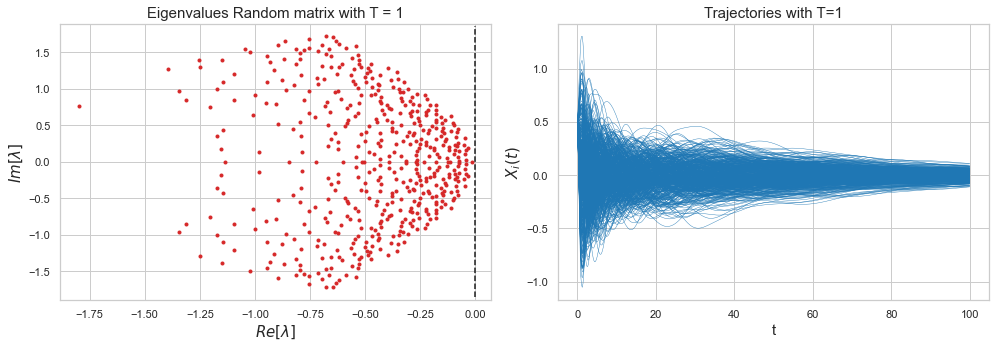

		 Initial Conditions:	 x(t) = random const in [0,1] for each element of x


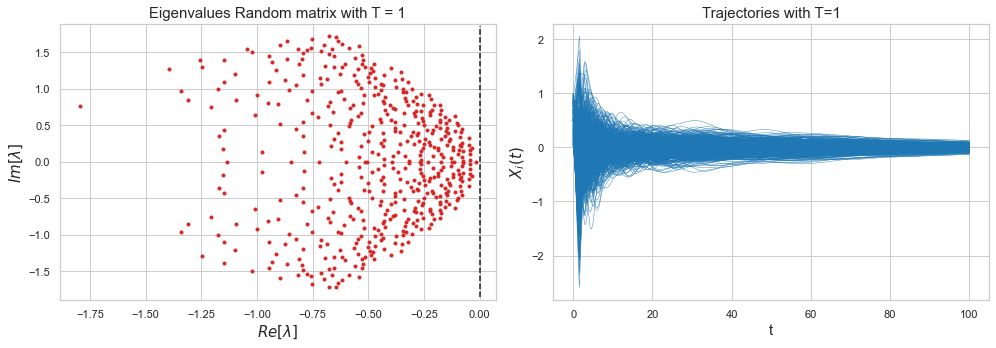

		 Initial Conditions:	 x(t) = 0.5(1+sin(2pi*t/T))


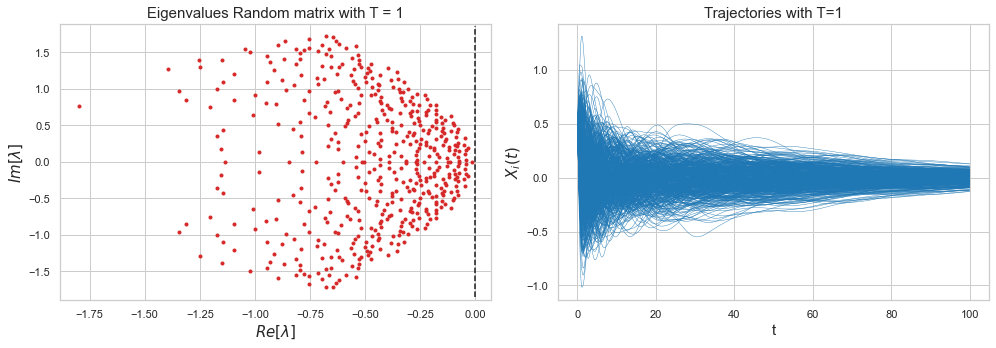

In [13]:
print('\t\t Initial Conditions:\t x(t) = const = 0.5')
# constant I.C.
g = lambda t: 0.5*np.ones(Class.S)
Show_Trajectory(A,B,g,T,time)
# random I.C.
print('\t\t Initial Conditions:\t x(t) = random const in [0,1] for each element of x')
dat = np.random.uniform(0,1,Class.S)
g = lambda t: dat
Show_Trajectory(A,B,g,T,time)
# sin I.C.
print('\t\t Initial Conditions:\t x(t) = 0.5(1+sin(2pi*t/T))')
frq = 2*np.pi*np.random.uniform(-1,1,Class.S)
g = lambda t: 0.5+0.5*np.sin(frq*t)
Show_Trajectory(A,B,g,T,time)

# A = -I, B = Random matrix (d=0)

In [14]:
#matrices
A = -np.eye(Class.S)
Class.ran_matrix()
B = Class.M
g = lambda t: 0.5*np.ones(Class.S)

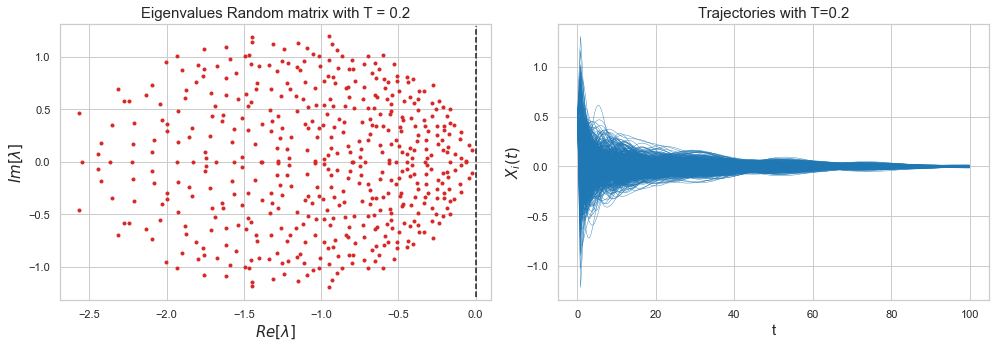

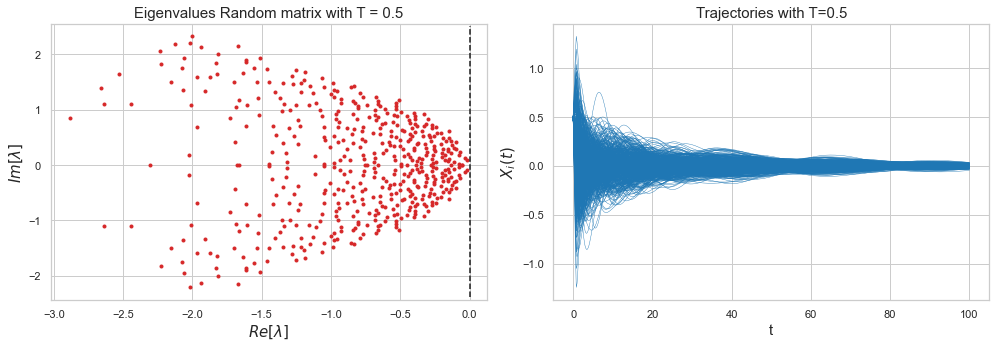

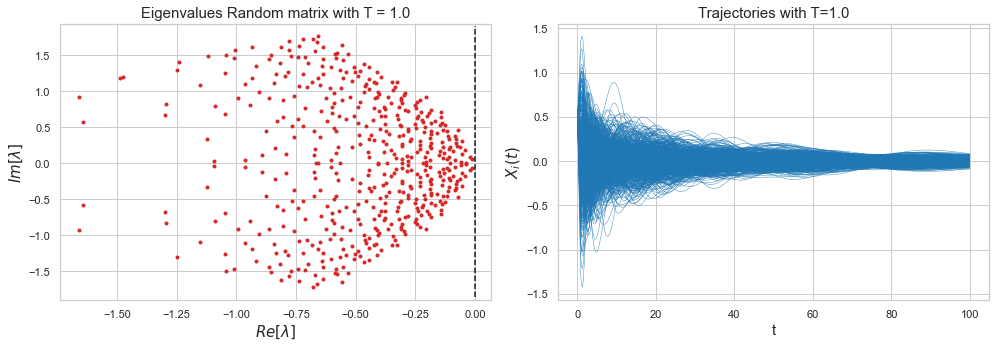

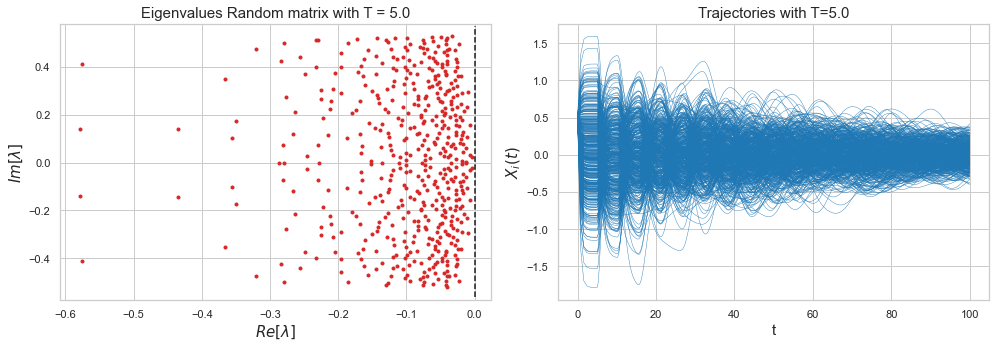

In [15]:
for T in [0.2,0.5,1.,5.]:
    Show_Trajectory(A,B,g,T,time)

# A = 0, B = Random matrix (d=-1)

In [16]:
#Define variables
Class.S = 500
Class.C = 361./500.
Class.d = 1
Class.sigma = 0.05

A = 0*np.eye(Class.S)
Class.ran_matrix()
B = Class.M
g = lambda t: 0.5*np.ones(Class.S)

In [17]:
print('Maximal eigenvalue of B: \t',Class.sigma*np.sqrt(Class.S*Class.C)-1)

Maximal eigenvalue of B: 	 -0.04999999999999993


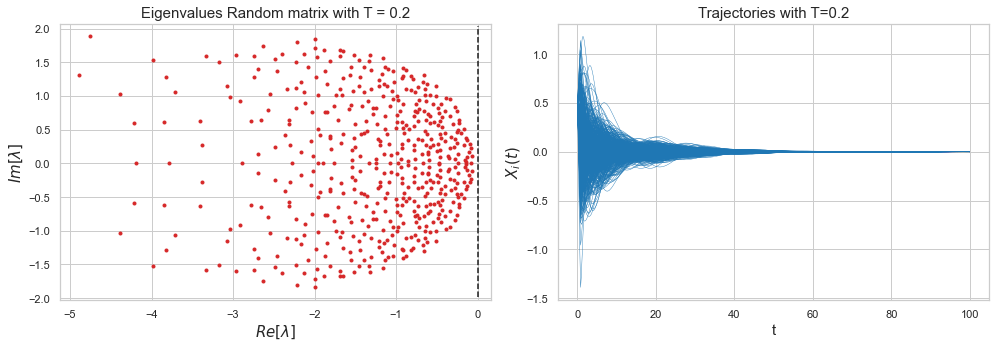

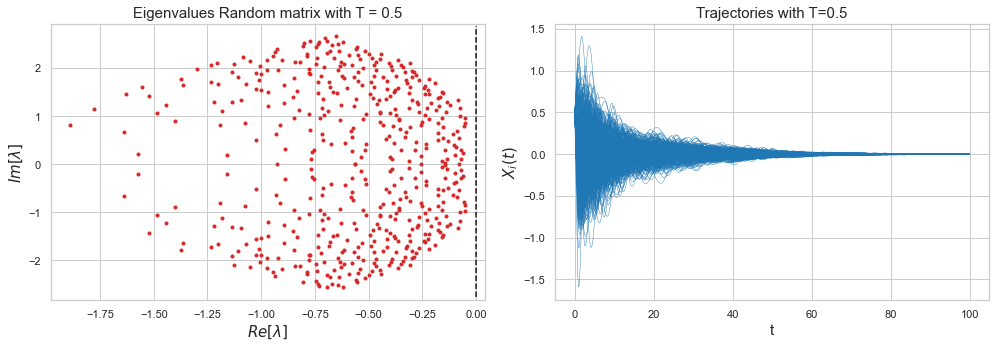

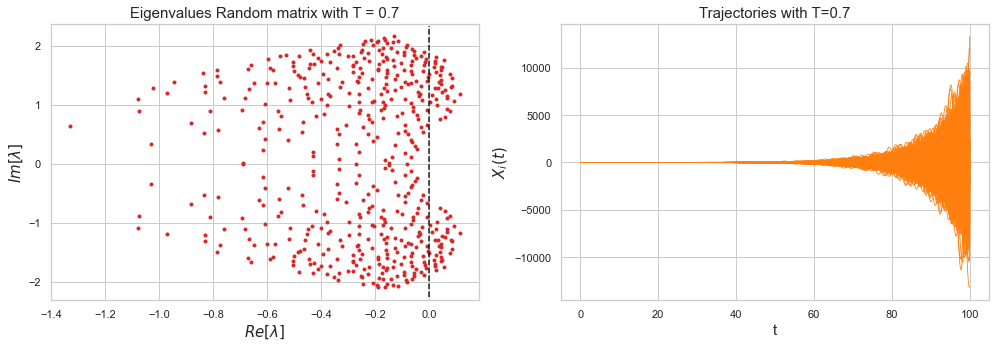

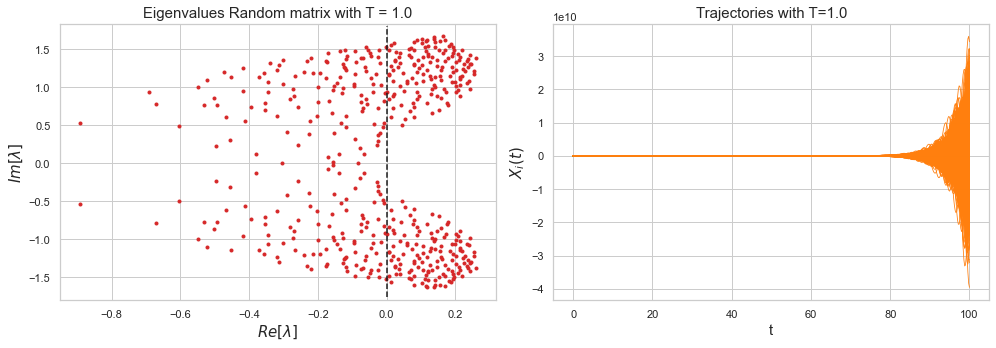

In [18]:
for T in [0.2,0.5,0.7,1.]:
    Show_Trajectory(A,B,g,T,time)

## Mixed matrix different delays

In [19]:
#Define variables
Class.S = 500
Class.C = 361./500.
Class.d = 1
Class.sigma = 0.05*np.pi/(np.pi+2)

A = 0*np.eye(Class.S)
Class.mix_matrix()
B = Class.M
g = lambda t: 0.5*np.ones(Class.S)

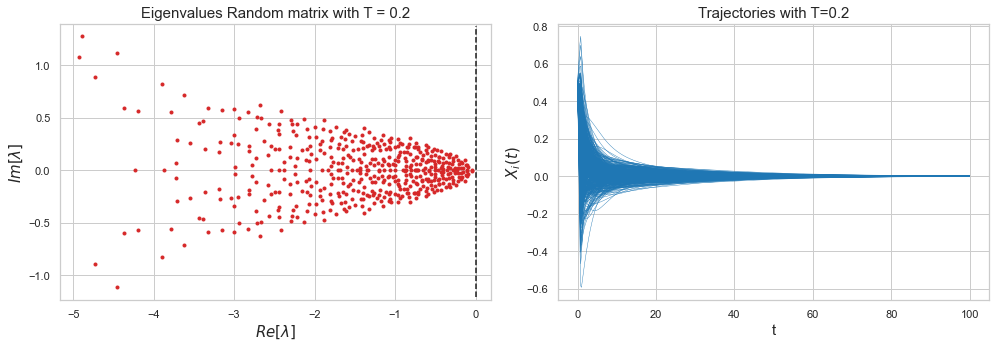

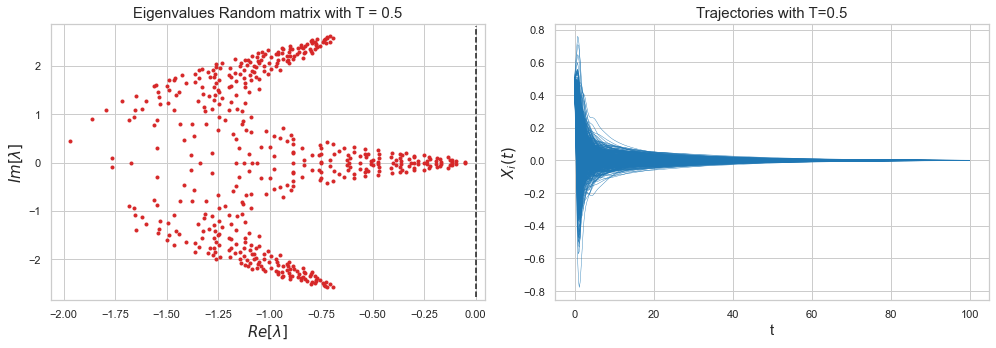

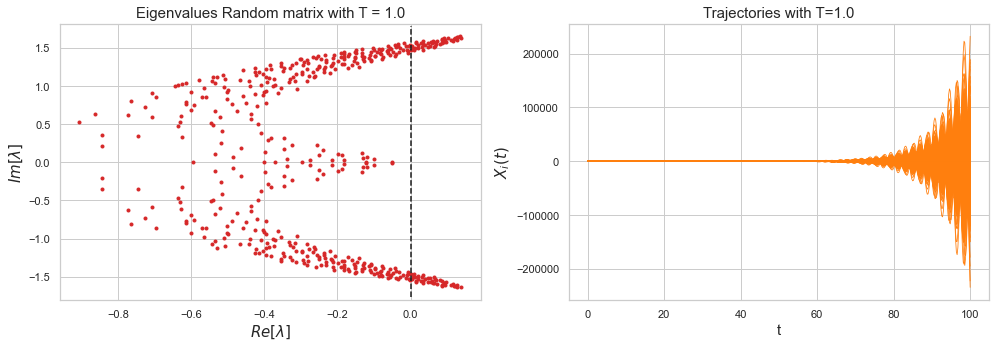

In [20]:
for T in [0.2,0.5,1.]:
    Show_Trajectory(A,B,g,T,time)

## Random matrices of different sizes and fixed delay T=0.7

In [21]:
#Define variables
Class.S = 500
Class.C = 361./500.
Class.d = 1
Class.sigma = 0.05

T=0.6

Size = 300



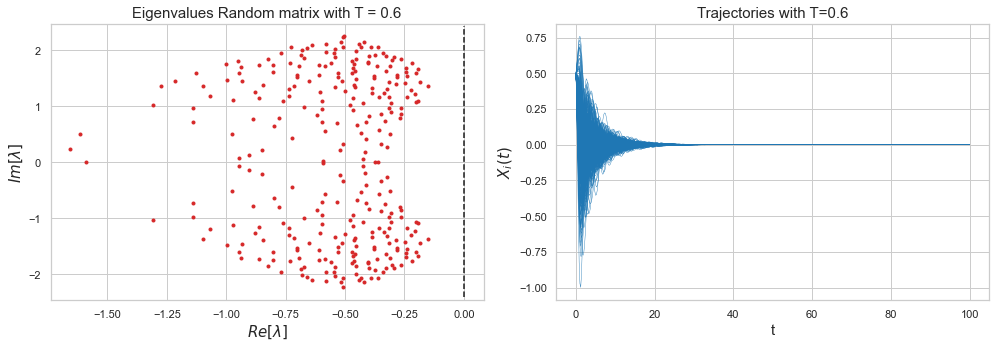

Size = 400



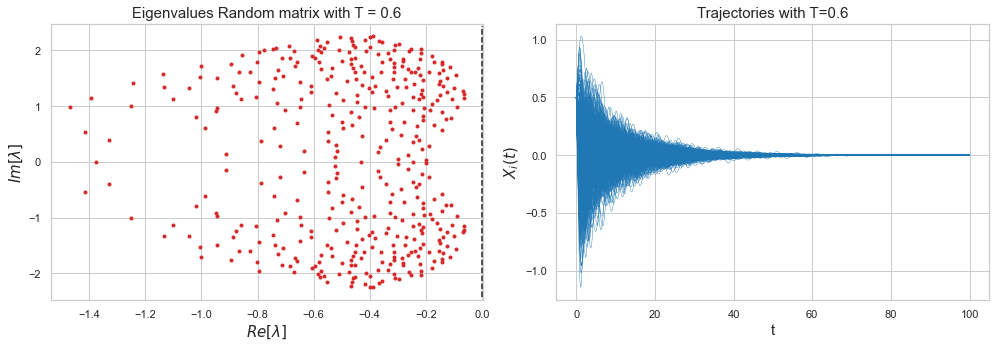

Size = 500



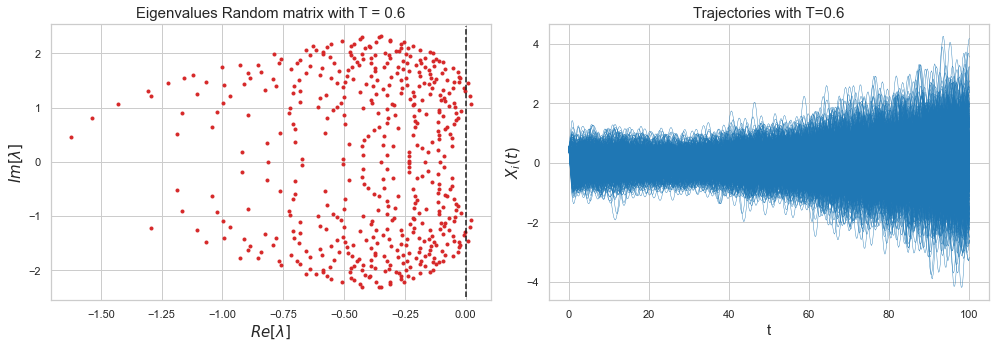

Size = 600



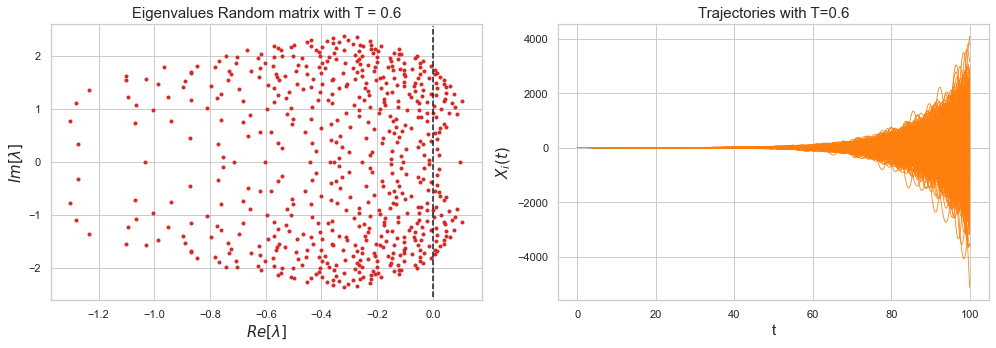

In [22]:
for S in [300,400,500,600]:
    print(f'Size = {S}'+'\n')
    Class.S = S
    A = 0*np.eye(Class.S)
    Class.ran_matrix()
    B = Class.M
    g = lambda t: 0.5*np.ones(Class.S)
    Show_Trajectory(A,B,g,T,time)

# A, B both random matrices

In [33]:
#time
dt = 0.2
tfin = 100
time = np.linspace(0, tfin, int(tfin/dt))

In [34]:
Class.S = 500
Class.C = 0.4
Class.sigma = 0.05
Class.d = 1

epsi=0.1
D = -Class.d*np.eye(Class.S)
#matrices
Class.ran_matrix()
B = Class.M
Class.d = 0
Class.ran_matrix()
A1 = Class.M
A = A1+D

T=1

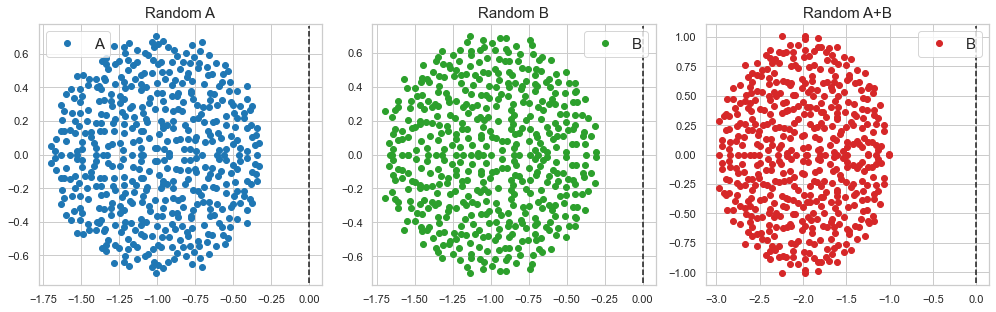

In [35]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(14,4.5)

plt.subplot(1,3,1)
evl = comp_eig(A)
plt.plot(evl.real, evl.imag,'o',color=color[0],label=f'A')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random A",fontsize=15)
plt.legend(fontsize=15)
plt.subplot(1,3,2)
evl = comp_eig(B)
plt.plot(evl.real, evl.imag,'o',color=color[2],label=f'B')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random B",fontsize=15)
plt.legend(fontsize=15)
plt.subplot(1,3,3)
evl = comp_eig(A+B)
plt.plot(evl.real, evl.imag,'o',color=color[3],label=f'B')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random A+B",fontsize=15)
plt.legend(fontsize=15)

fig.tight_layout()
plt.show(fig)

		 Initial Conditions:	 x(t) = const = 0.5


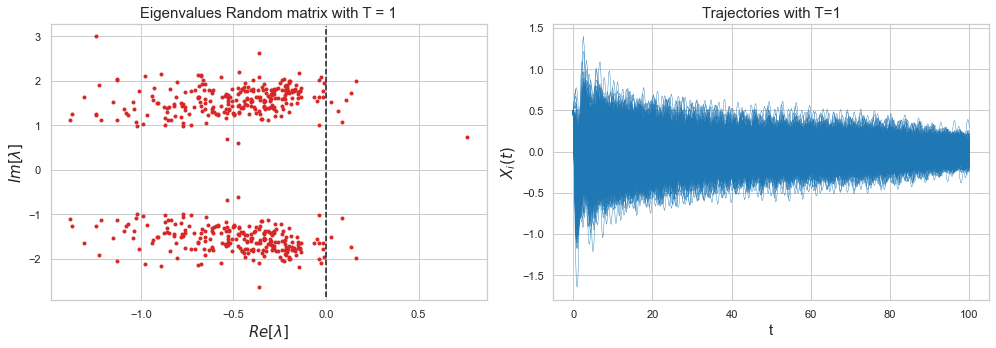

		 Initial Conditions:	 x(t) = random const in [0,1] for each element of x


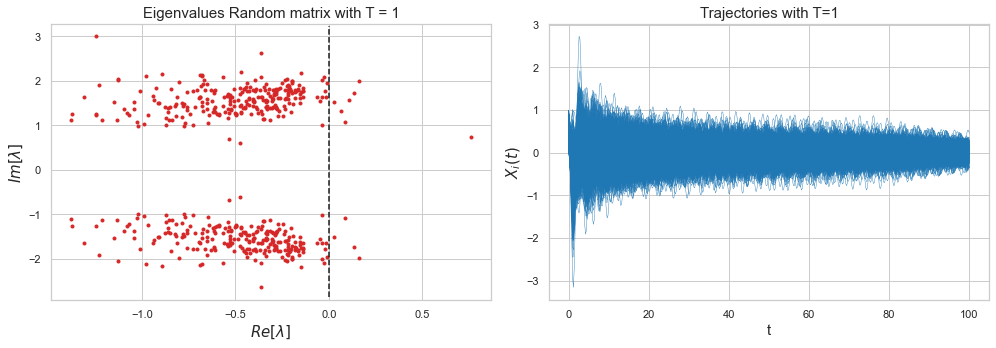

		 Initial Conditions:	 x(t) = 0.5(1+sin(2pi*t/T)) with T random


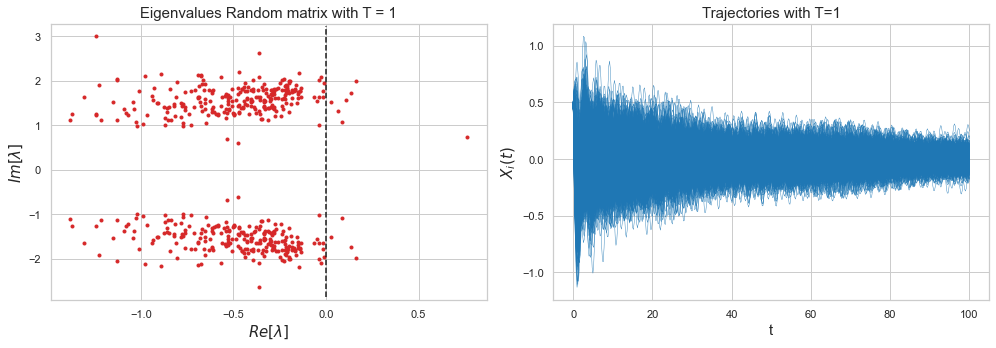

In [36]:
print('\t\t Initial Conditions:\t x(t) = const = 0.5')
# constant I.C.
g = lambda t: 0.5*np.ones(Class.S)
Show_Trajectory(A1,B,g,T,time,both=True,D=D,epsi=epsi)
# random I.C.
print('\t\t Initial Conditions:\t x(t) = random const in [0,1] for each element of x')
dat = np.random.uniform(0,1,Class.S)
g = lambda t: dat
Show_Trajectory(A1,B,g,T,time,both=True,D=D,epsi=epsi)
# sin I.C.
print('\t\t Initial Conditions:\t x(t) = 0.5(1+sin(2pi*t/T)) with T random')
frq = 2*np.pi*np.random.uniform(-1,1,Class.S)
g = lambda t: 0.5+0.5*np.sin(frq*t)
Show_Trajectory(A1,B,g,T,time,both=True,D=D,epsi=epsi)

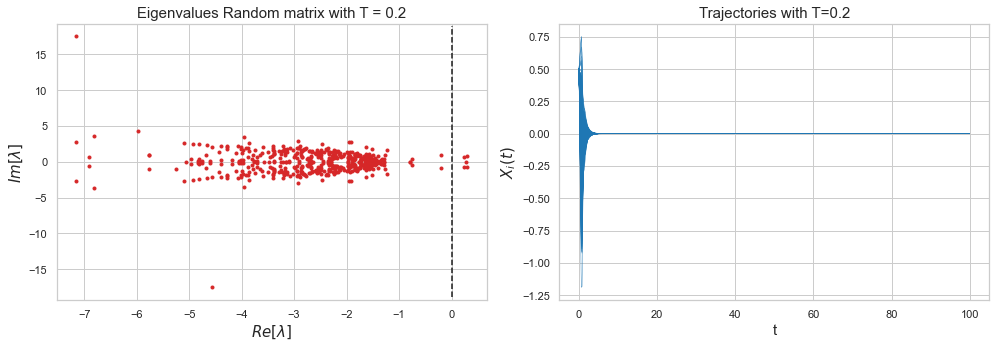

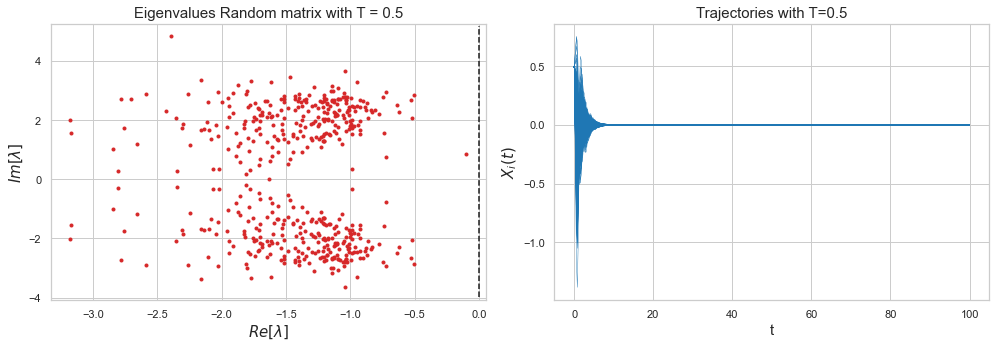

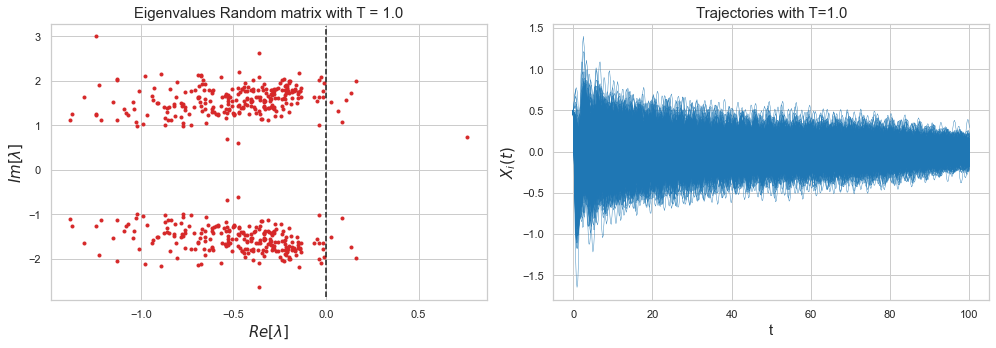

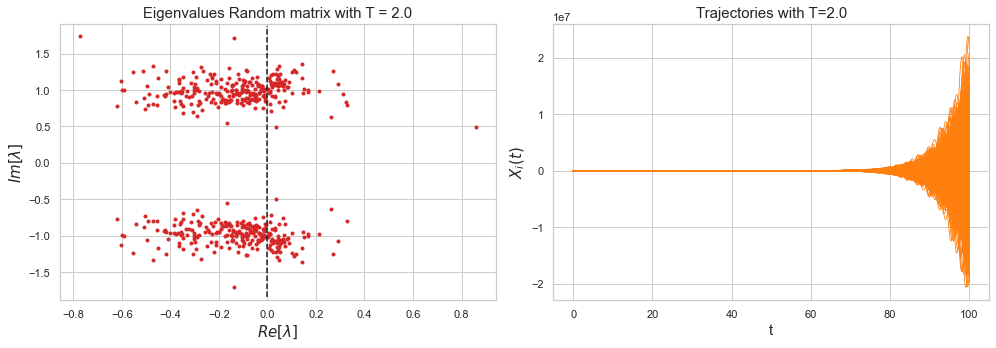

In [37]:
g = lambda t: 0.5*np.ones(Class.S)
for T in [0.2,0.5,1.,2.]:
    Show_Trajectory(A1,B,g,T,time,both=True,D=D,epsi=epsi)

In [51]:
Class.S = 500
Class.C = 0.4
Class.sigma = 0.12#0.08
Class.d = 1

epsi=0.1
D = -Class.d*np.eye(Class.S)
#matrices
Class.ran_matrix()
B = Class.M
Class.d = 0
Class.sigma = 0.01
Class.ran_matrix()
A1 = Class.M
A = A1+D

T=1

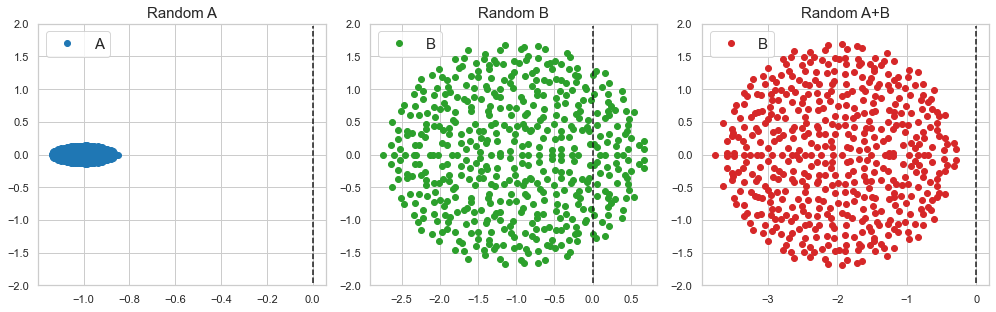

In [52]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(14,4.5)

plt.subplot(1,3,1)
evl = comp_eig(A)
plt.plot(evl.real, evl.imag,'o',color=color[0],label=f'A')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylim(-2,2)
plt.title("Random A",fontsize=15)
plt.legend(fontsize=15)
plt.subplot(1,3,2)
evl = comp_eig(B)
plt.plot(evl.real, evl.imag,'o',color=color[2],label=f'B')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylim(-2,2)
plt.title("Random B",fontsize=15)
plt.legend(fontsize=15)
plt.subplot(1,3,3)
evl = comp_eig(A+B)
plt.plot(evl.real, evl.imag,'o',color=color[3],label=f'B')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylim(-2,2)
plt.title("Random A+B",fontsize=15)
plt.legend(fontsize=15)

fig.tight_layout()
plt.show(fig)

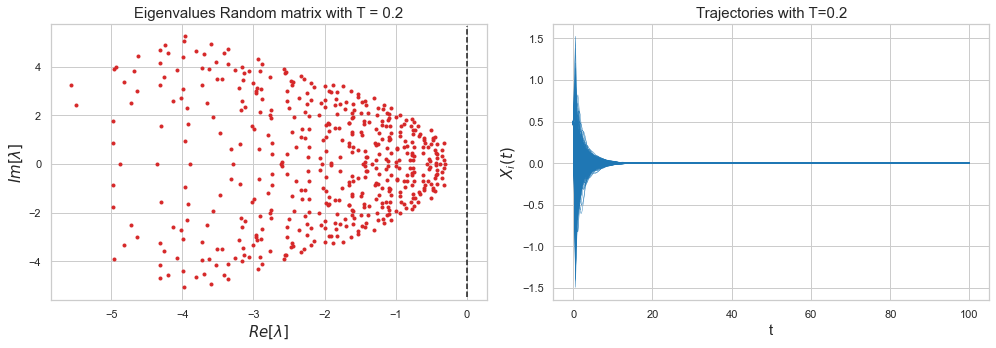

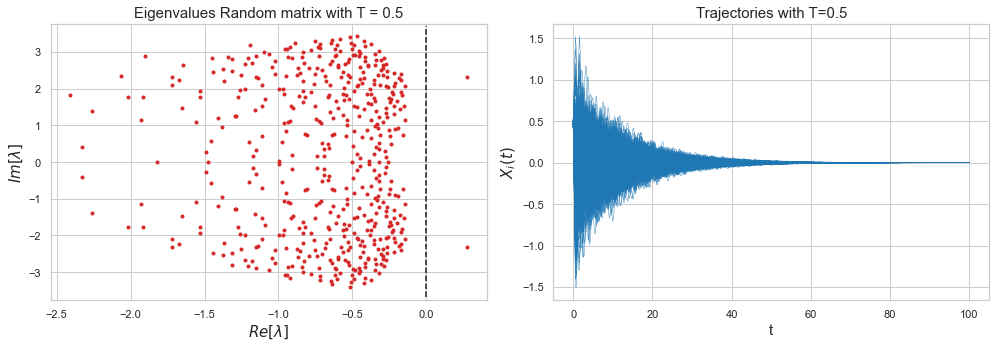

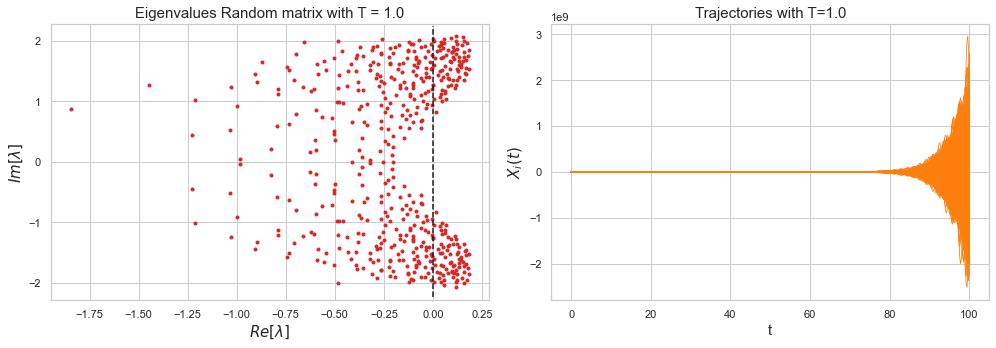

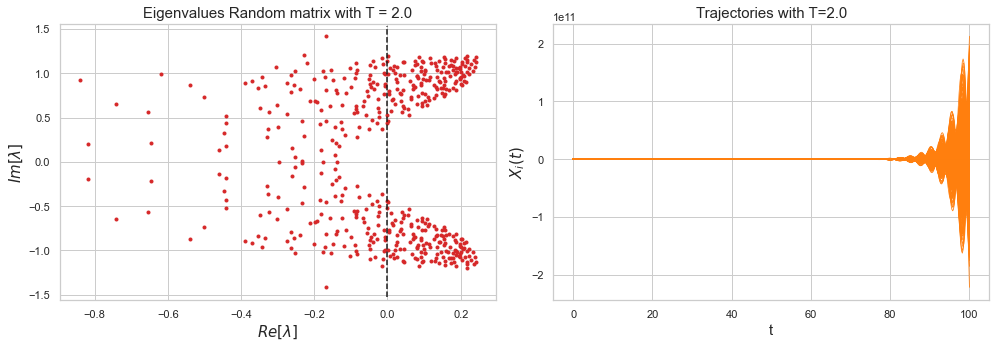

In [40]:
g = lambda t: 0.5*np.ones(Class.S)
for T in [0.2,0.5,1.,2.]:
    Show_Trajectory(A1,B,g,T,time,both=True,D=D,epsi=epsi)

In [53]:
Class.S = 500
Class.C = 0.4
Class.sigma = 0.06
Class.d = 0

epsi=0.1
D = -np.eye(Class.S)
#matrices
Class.ran_matrix()
B = Class.M
Class.sigma = 0.015
Class.ran_matrix()
A1 = Class.M
A = A1+D

T=1

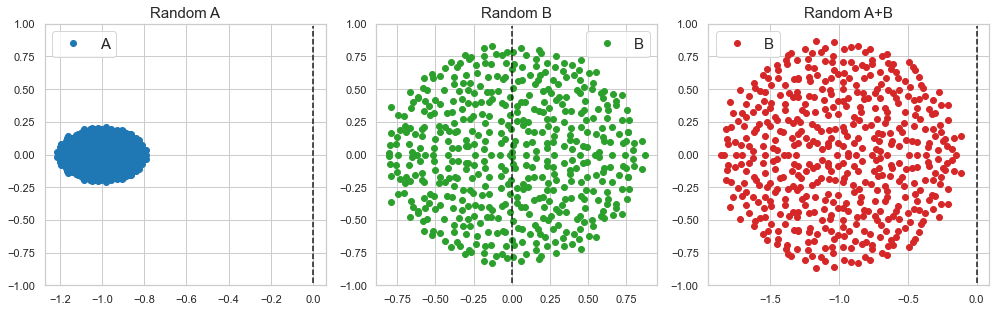

In [54]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(14,4.5)

plt.subplot(1,3,1)
evl = comp_eig(A)
plt.plot(evl.real, evl.imag,'o',color=color[0],label=f'A')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylim(-1,1)
plt.title("Random A",fontsize=15)
plt.legend(fontsize=15)
plt.subplot(1,3,2)
evl = comp_eig(B)
plt.plot(evl.real, evl.imag,'o',color=color[2],label=f'B')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylim(-1,1)
plt.title("Random B",fontsize=15)
plt.legend(fontsize=15)
plt.subplot(1,3,3)
evl = comp_eig(A+B)
plt.plot(evl.real, evl.imag,'o',color=color[3],label=f'B')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylim(-1,1)
plt.title("Random A+B",fontsize=15)
plt.legend(fontsize=15)

fig.tight_layout()
plt.show(fig)

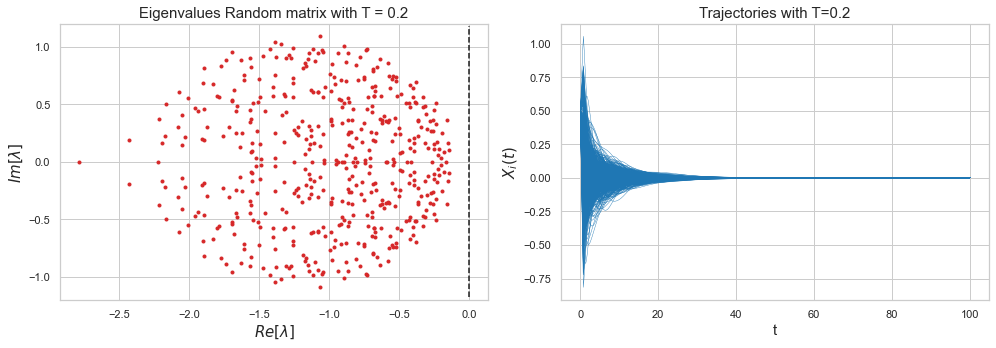

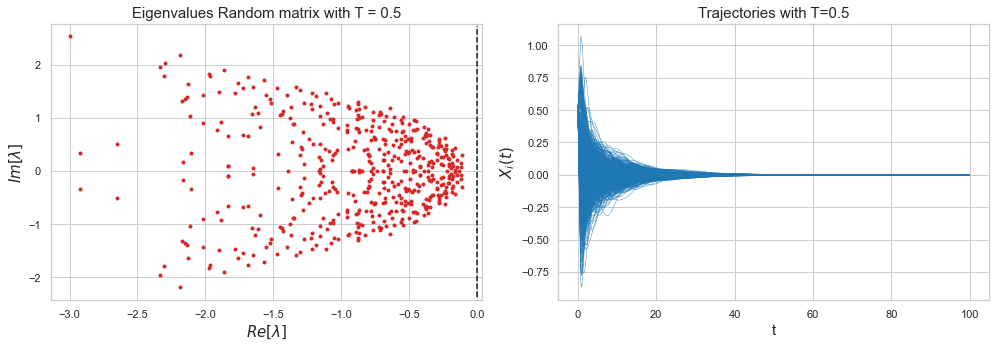

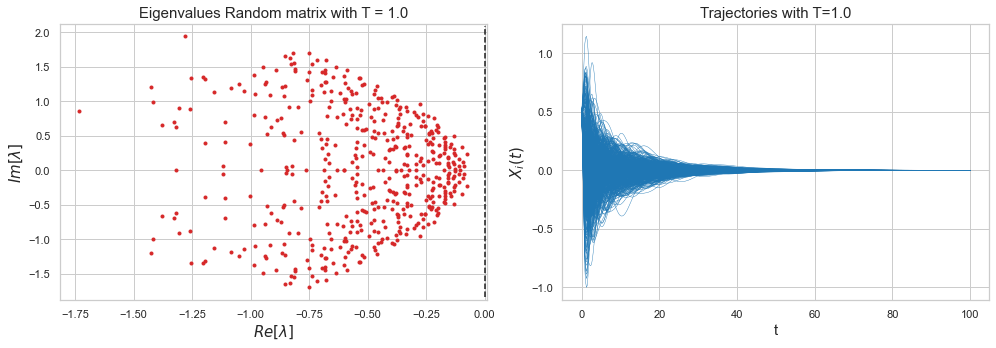

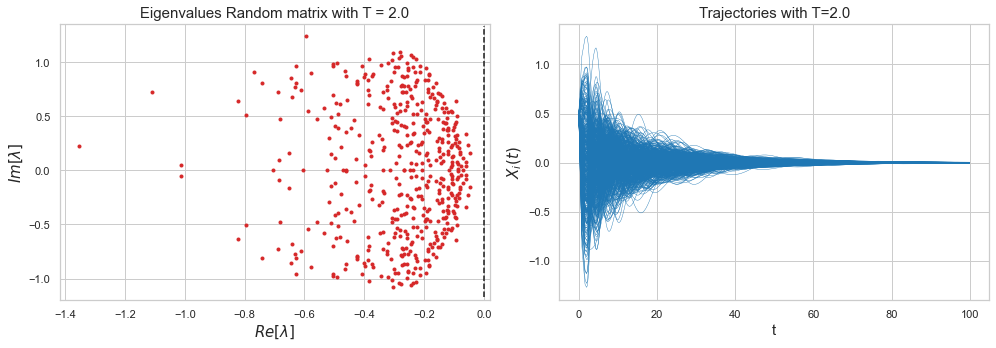

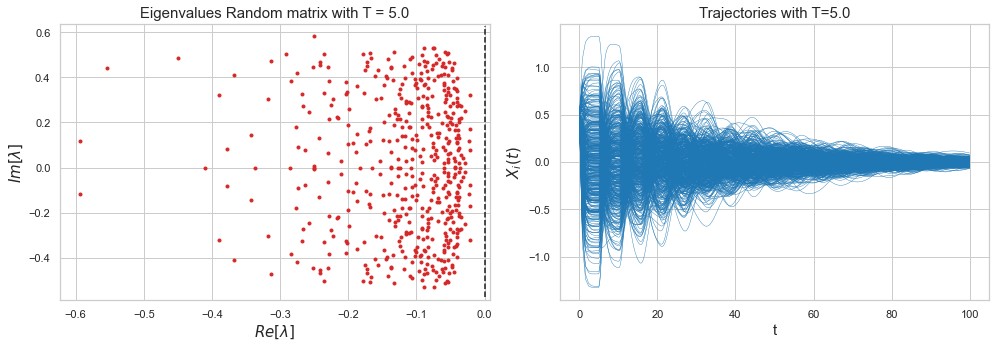

In [43]:
g = lambda t: 0.5*np.ones(Class.S)
for T in [0.2,0.5,1.,2.,5.]:
    Show_Trajectory(A1,B,g,T,time,both=True,D=D,epsi=epsi)

# Stability

In [11]:
# If sys is stable return True otherwise return False
def stability(A,B,T,time):
    g = lambda t: 0.5*np.ones(A.shape[0])
    y = ddeint(model, g, time, fargs=(T,A,B,))
    bol = np.mean(abs(y[-int(len(time)/10):,:]))<1
    return bol

In [12]:
#time
dt = 0.2
tfin = 100
time = np.linspace(0, tfin, int(tfin/dt))

In [13]:
Class.S = 200
Class.C = 0.6
Class.sigma = 0.15
Class.d = 1

#matrices
Class.ran_matrix()
A = Class.M
Class.ran_matrix()
B = Class.M

## Iterative method

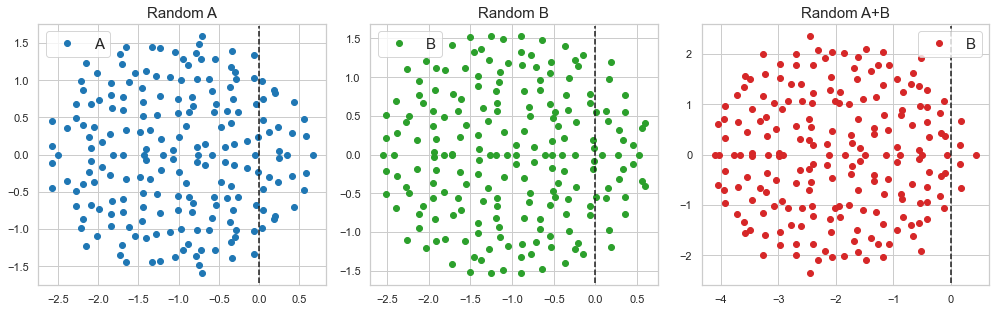

In [14]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(14,4.5)

plt.subplot(1,3,1)
evl = comp_eig(A)
plt.plot(evl.real, evl.imag,'o',color=color[0],label=f'A')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random A",fontsize=15)
plt.legend(fontsize=15)
plt.subplot(1,3,2)
evl = comp_eig(B)
plt.plot(evl.real, evl.imag,'o',color=color[2],label=f'B')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random B",fontsize=15)
plt.legend(fontsize=15)
plt.subplot(1,3,3)
evl = comp_eig(A+B)
plt.plot(evl.real, evl.imag,'o',color=color[3],label=f'B')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random A+B",fontsize=15)
plt.legend(fontsize=15)

fig.tight_layout()
plt.show(fig)

In [14]:
Tvec = np.linspace(2.,0.04,33)#np.linspace(2.,0.1,20)
S_val = np.zeros(len(Tvec))
S_val_a = np.zeros(len(Tvec))
S_val_b = np.zeros(len(Tvec))

#first iter
Svec1 = np.linspace(6,24,10,dtype=int)

N=4
for n in range(N):
    print(n)
    res = np.zeros(len(Svec1))-1
    for i,S in enumerate(Svec1):
        if i%2==0 and N==1:
            print(i/len(Svec1)*100,'%')
        #create matrices
        Class.S = S
        Class.d = 1
        Class.ran_matrix()
        A = Class.M
        Class.ran_matrix()
        B = Class.M
        #find stable value
        T = Tvec[0]
        res[i] = 2*stability(A,B,T,time)-1
        if res[i]<0:
            break

    ind = res>0
    S_val[0] += Svec1[ind][-1]/N
S_val_a[0] = 2
S_val_b[0] = 2

0
1
2
3


In [15]:
Tot1,Tot2,Tot3 = np.zeros(len(Tvec)),np.zeros(len(Tvec)),np.zeros(len(Tvec))
for n in range(N):
    print(n)
    for i,T in enumerate(Tvec):
        if i != 0:
            if i%int(len(Tvec)/10)==0 and N==1 :
                print(i/len(Tvec)*100,'%','\t S = ', S_val[i-1], ' ', S_val_a[i-1], ' ', S_val_b[i-1])
            ii = -2
            bol = True
            while bol:
                ii += 2
                #create matrices
                Class.S = int(S_val[i-1]+ii)
                Class.d=1
                Class.ran_matrix()
                A = Class.M
                Class.ran_matrix()
                B = Class.M
                #find stable value
                bol = stability(A,B,T,time)
            if Class.S == int(S_val[i-1]):
                S_val[i] = S_val[i-1]
            else:
                S_val[i] = (Class.S-2)
            jj = -2
            bol1 = True
            while bol1:
                jj += 2
                #create matrices
                Class.S = int(S_val_a[i-1]+jj)
                Class.d=0
                Class.ran_matrix()
                A = Class.M
                Class.d=1
                Class.ran_matrix()
                B = Class.M
                #find stable value
                bol1 = stability(A,B,T,time)
            if Class.S == int(S_val_a[i-1]):
                S_val_a[i] = S_val_a[i-1]
            else:
                S_val_a[i] = (Class.S-2)
            kk = -2
            bol2 = True
            while bol2:
                kk += 2
                #create matrices
                Class.S = int(S_val_b[i-1]+kk)
                Class.d=1
                Class.ran_matrix()
                A = Class.M
                Class.d=0
                Class.ran_matrix()
                B = Class.M
                #find stable value
                bol2 = stability(A,B,T,time)
            if Class.S == int(S_val_b[i-1]):
                S_val_b[i] = S_val_b[i-1]
            else:
                S_val_b[i] = (Class.S-2)
    Tot1 += S_val/N
    Tot2 += S_val_a/N
    Tot3 += S_val_b/N

S_val = Tot1
S_val_a = Tot2
S_val_b = Tot3

S_val_a[0] = S_val_a[1]
S_val_b[0] = S_val_b[1]
ind = S_val_a < 3
S_val_a[ind] = 0

0
1
2
3


In [16]:
N = 10
S_val1 = np.zeros(len(Tvec))
S_val2 = np.zeros(len(Tvec))
S_val3 = np.zeros(len(Tvec))
#first iter
Svec1 = np.linspace(10,80,11,dtype=int)
for n in range(N):
    print(n)
    res = np.zeros(len(Svec1))
    res1 = np.zeros(len(Svec1))
    res2 = np.zeros(len(Svec1))
    for i,S in enumerate(Svec1):
        if i%2==0 and N==1:
            print(i/len(Svec1)*100,'%')
        #create matrices
        Class.S = S
        A = -np.eye(S)
        Class.d=1
        Class.ran_matrix()
        B = Class.M
        Class.d=0
        Class.ran_matrix()
        MM = Class.M
        #find stable value
        T = Tvec[0]
        evl = comp_eig_delay(A,B,T)
        bol = np.amax(evl.real)<0
        res[i] = 2*bol-1
        evl = comp_eig_delay(0,B,T)
        bol = np.amax(evl.real)<0
        res2[i] = 2*bol-1
        evl = comp_eig_delay(A,MM,T)
        bol = np.amax(evl.real)<0
        res1[i] = 2*bol-1
    ind = res>0
    S_val1[0] += Svec1[ind][-1]/N
    ind = res1>0
    S_val3[0] += Svec1[ind][-1]/N
    ind = res2>0
    if len(Svec1[ind])>1:
        S_val2[0] += Svec1[ind][-1]/N
    else:
        S_val2[0] = 0

0
1
2
3
4
5
6
7
8
9


In [17]:
for n in range(N):
    print(n)
    for i,T in enumerate(Tvec):
        if i != 0:
            if i%int(len(Tvec)/10)==0 and N==1:
                print(i/len(Tvec)*100,'%','\t S = ', S_val1[i-1],' , ', S_val2[i-1],' , ', S_val3[i-1])
            #A=-1
            ii = -2
            bol = True
            Class.S = int(S_val1[i-1]*N/(n+1))
            if i==1:
                Class.S = int(S_val1[i-1])
            while bol:
                ii += 2
                #create matrices
                if Class.S>0:
                    Class.S = int(Class.S+2)
                else:
                    Class.S = 2
                A = -np.eye(Class.S)
                Class.d=1
                Class.ran_matrix()
                B = Class.M
                #find stable value
                evl = comp_eig_delay(A,B,T)
                bol = np.amax(evl.real)<0
            S_val1[i] += (Class.S-2)/N
            #A=0
            jj = -2
            bol1 = True
            Class.S = int(S_val2[i-1]*N/(n+1))
            if i==1:
                Class.S = int(S_val2[i-1])
            while bol1:
                jj += 2
                #create matrices
                if Class.S>0:
                    Class.S = int(Class.S+2)
                else:
                    Class.S = 2
                A = 0
                Class.d=1
                Class.ran_matrix()
                B = Class.M
                #find stable value
                evl = comp_eig_delay(A,B,T)
                bol1 = np.amax(evl.real)<0
            S_val2[i] += (Class.S-2)/N
            #A=-1
            kk = -2
            bol2 = True
            Class.S = int(S_val3[i-1]*N/(n+1))
            if i==1:
                Class.S = int(S_val3[i-1])
            while bol2:
                kk += 2
                #create matrices
                if Class.S>0:
                    Class.S = int(Class.S+2)
                else:
                    Class.S = 2
                A = -np.eye(Class.S)
                Class.d=0
                Class.ran_matrix()
                B = Class.M
                #find stable value
                evl = comp_eig_delay(A,B,T)
                bol2 = np.amax(evl.real)<0
            S_val3[i] += (Class.S-2)/N

0
1
2
3
4
5
6
7
8
9


In [18]:
S_val0 = 0
for n in range(N):
    print(n)
    ii = -2
    bol = True
    while bol:
        ii += 2
        #create matrices
        Class.S = int(S_val[-1]-4+ii)
        Class.d=1
        Class.ran_matrix()
        A = Class.M
        Class.ran_matrix()
        B = Class.M
        #find stable value
        evl = comp_eig(A+B)
        bol = np.amax(evl.real)<0
    S_val0 += (Class.S-2)/N

0
1
2
3
4
5
6
7
8
9


In [15]:
#ARR = np.zeros((len(Tvec),8))
#ARR[:,0] = Tvec
#ARR[:,1] = np.array([S_val0]*len(Tvec))
#ARR[:,2] = S_val1
#ARR[:,3] = S_val3
#ARR[:,4] = S_val2
#ARR[:,5] = S_val
#ARR[:,6] = S_val_a
#ARR[:,7] = S_val_b
#np.save('SOLVER_data.npy',ARR)
ARR = np.load('data/SOLVER_data.npy')
Tvec   = ARR[:,0]
S_val0 = ARR[0,1]
S_val1 = ARR[:,2]
S_val3 = ARR[:,3]
S_val2 = ARR[:,4]
S_val  = ARR[:,5]
S_val_a= ARR[:,6]
S_val_b= ARR[:,7]

In [17]:
sns.set(style='darkgrid')

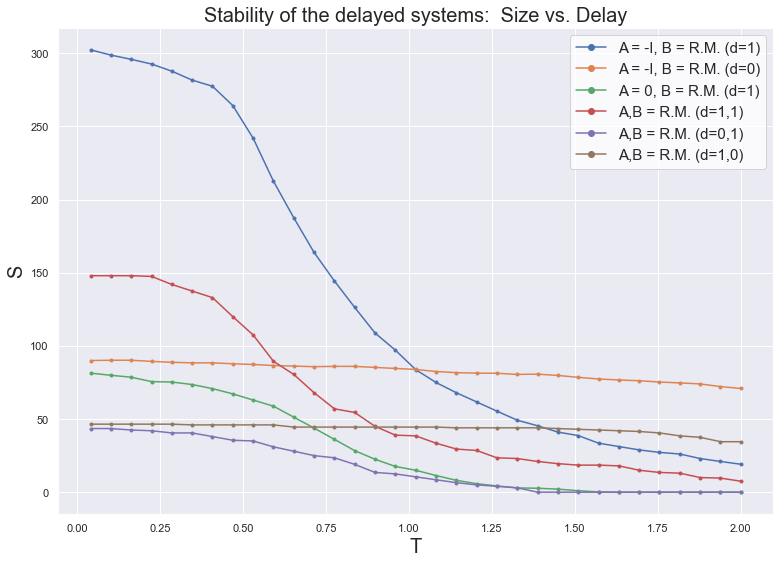

In [19]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(11,8)

plt.plot(Tvec,S_val1,'.-')
plt.plot(Tvec,S_val3,'.-')
plt.plot(Tvec,S_val2,'.-')
plt.plot(Tvec,S_val,'.-')
plt.plot(Tvec,S_val_a,'.-')
plt.plot(Tvec,S_val_b,'.-')
#plt.plot(Tvec,[S_val0]*len(Tvec),'k--') # label='lim. stability A,B = R.M. (T=0)'

plt.xlabel('T',fontsize=20)
plt.ylabel('S',fontsize=20)
#plt.yscale('log')
plt.title("Stability of the delayed systems:  Size vs. Delay",fontsize=20)
plt.legend(['A = -I, B = R.M. (d=1)','A = -I, B = R.M. (d=0)',
            'A = 0, B = R.M. (d=1)','A,B = R.M. (d=1,1)','A,B = R.M. (d=0,1)','A,B = R.M. (d=1,0)'], 
           fontsize=15,markerscale=2,loc='upper right',facecolor='w')

fig.tight_layout()
plt.show(fig)
fig.savefig('final_figures/Stability_ran_C0.6_s0.15.png',format='png')

# Stability comparison perturbation method

In [ ]:
Class.S = 100
Class.C = 0.6
sigma = 0.15
multiplier = 0.2
Class.sigma = sigma
Class.d = 1

In [41]:
Tvec = np.linspace(2.,0.04,33)#np.linspace(2.,0.1,20)
S_val = np.zeros(len(Tvec))

#first iter
Svec1 = np.linspace(15,25,10,dtype=int)

N=4
for n in range(N):
    print(n)
    res = np.zeros(len(Svec1))-1
    for i,S in enumerate(Svec1):
        if i%2==0 and N==1:
            print(i/len(Svec1)*100,'%')
        #create matrices
        Class.S = S
        Class.d = 1
        Class.sigma = multiplier*sigma
        Class.ran_matrix()
        A = Class.M
        Class.sigma = sigma
        Class.ran_matrix()
        B = Class.M
        #find stable value
        T = Tvec[0]
        res[i] = 2*stability(A,B,T,time)-1
        if res[i]<0:
            break

    ind = res>0
    S_val[0] += Svec1[ind][-1]/N

0
1
2
3


In [ ]:
Tot1 = np.zeros(len(Tvec))
for n in range(N):
    print(n)
    for i,T in enumerate(Tvec):
        if i != 0:
            if i%int(len(Tvec)/10)==0 and N==1 :
                print(i/len(Tvec)*100,'%','\t S = ', S_val[i-1])
            ii = -2
            bol = True
            while bol:
                ii += 2
                #create matrices
                Class.S = int(S_val[i-1]+ii)
                Class.d=1
                Class.sigma = multiplier*sigma
                Class.ran_matrix()
                A = Class.M
                Class.sigma = sigma
                Class.ran_matrix()
                B = Class.M
                #find stable value
                bol = stability(A,B,T,time)
            if Class.S == int(S_val[i-1]):
                S_val[i] = S_val[i-1]
            else:
                S_val[i] = (Class.S-2)
     
    Tot1 += S_val/N

S_val = Tot1

0
1
2


In [ ]:
epsi = 0.1

N = 10
S_val1 = np.zeros(len(Tvec))
#first iter
Svec1 = np.linspace(20,30,10,dtype=int)
for n in range(N):
    print(n)
    res = np.zeros(len(Svec1))
    for i,S in enumerate(Svec1):
        if i%2==0 and N==1:
            print(i/len(Svec1)*100,'%')
        #create matrices
        Class.S = S
        Class.d=0
        Class.sigma = multiplier*sigma
        Class.ran_matrix()
        A = Class.M
        D = -np.eye(Class.S)
        Class.d=1
        Class.sigma = sigma
        Class.ran_matrix()
        B = Class.M
        #find stable value
        T = Tvec[0]
        evl = eig_perturb (D,A/epsi,B,T,epsi,symm='no')
        bol = np.amax(evl.real)<0
        res[i] = 2*bol-1
    ind = res>0
    S_val1[0] += Svec1[ind][-1]/N

In [ ]:
for n in range(N):
    print(n)
    for i,T in enumerate(Tvec):
        if i != 0:
            if i%int(len(Tvec)/10)==0 and N==1:
                print(i/len(Tvec)*100,'%','\t S = ', S_val1[i-1])

            ii = -2
            bol = True
            Class.S = int(S_val1[i-1]*N/(n+1))
            if i==1:
                Class.S = int(S_val1[i-1])
            while bol:
                ii += 2
                #create matrices
                if Class.S>0:
                    Class.S = int(Class.S+2)
                else:
                    Class.S = 2
                Class.d=0
                Class.sigma = multiplier*sigma
                Class.ran_matrix()
                A = Class.M
                D = -np.eye(Class.S)
                Class.d=1
                Class.sigma = sigma
                Class.ran_matrix()
                B = Class.M
                #find stable value
                evl = eig_perturb (D,A/epsi,B,T,epsi,symm='no')
                bol = np.amax(evl.real)<0
            S_val1[i] += (Class.S-2)/N

In [24]:
ARR = np.load('SOLVER_data.npy')
#Tvec   = ARR[:,0]
S_val_1 = ARR[:,2]
S_val_0 = ARR[:,4]
#S_val_11  = ARR[:,5]

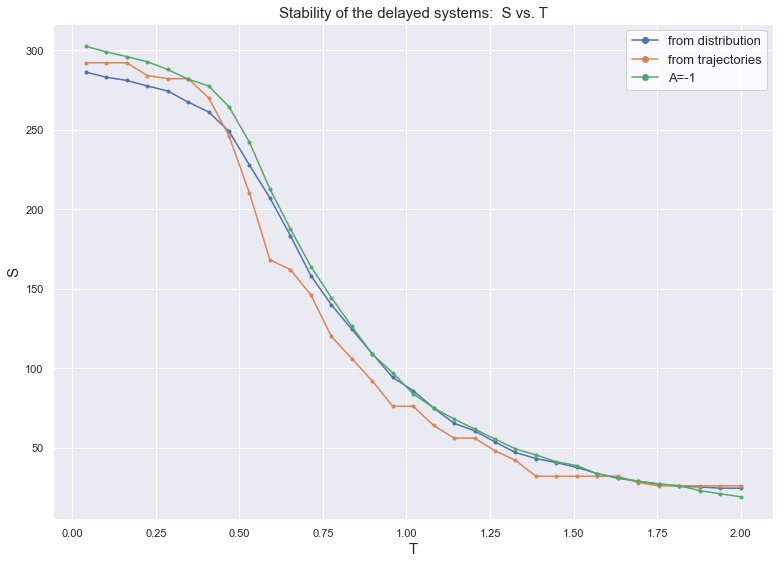

In [35]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(11,8)

plt.plot(Tvec,S_val1,'.-')
plt.plot(Tvec,S_val,'.-')
plt.plot(Tvec,S_val_1,'.-')
#plt.plot(Tvec,S_val_0,'.-')
#plt.plot(Tvec,S_val_11,'.-')

plt.xlabel('T',fontsize=15)
plt.ylabel('S',fontsize=15)
#plt.yscale('log')
plt.title("Stability of the delayed systems:  S vs. T",fontsize=15)
plt.legend(['from distribution','from trajectories','A=-1'], 
           fontsize=13,markerscale=2,loc='upper right',facecolor='w')

fig.tight_layout()
plt.show(fig)
#fig.savefig('final_figures/Stability_COMPARISON_ran_C0.6_s0.15.png',format='png')

In [21]:
Class.S = 100
Class.C = 0.6
sigma = 0.15
multi = [1,0.5,0.3,0.1,0.01]
Tvec = np.linspace(2.,0.04,33)
Class.sigma = sigma
Class.d = 1

In [22]:
epsi = 0.1

N = 20
S_val1 = np.zeros((len(Tvec),len(multi)))
#first iter
Svec1 = np.linspace(10,35,25,dtype=int)
for k,multiplier in enumerate(multi):
    print(k)
    for n in range(N):
        res = np.zeros(len(Svec1))
        for i,S in enumerate(Svec1):
            if i%2==0 and N==1:
                print(i/len(Svec1)*100,'%')
            #create matrices
            Class.S = S
            Class.d=0
            Class.sigma = multiplier*sigma
            Class.ran_matrix()
            A = Class.M
            D = -np.eye(Class.S)
            Class.d=1
            Class.sigma = sigma
            Class.ran_matrix()
            B = Class.M
            #find stable value
            T = Tvec[0]
            evl = eig_perturb (D,A/epsi,B,T,epsi,symm='no')
            bol = np.amax(evl.real)<0
            res[i] = 2*bol-1
        ind = res>0
        S_val1[0,k] += Svec1[ind][-1]/N

0
1
2
3
4


In [23]:
for k,multiplier in enumerate(multi):
    print(k)
    for n in range(N):
        for i,T in enumerate(Tvec):
            if i != 0:
                if i%int(len(Tvec)/10)==0 and N==1:
                    print(i/len(Tvec)*100,'%','\t S = ', S_val1[i-1,k])
                ii = -2
                bol = True
                Class.S = int(S_val1[i-1,k]*N/(n+1))
                if i==1:
                    Class.S = int(S_val1[i-1,k])
                while bol:
                    ii += 2
                    #create matrices
                    if Class.S>0:
                        Class.S = int(Class.S+2)
                    else:
                        Class.S = 2
                    Class.d=0
                    Class.sigma = multiplier*sigma
                    Class.ran_matrix()
                    A = Class.M
                    D = -np.eye(Class.S)
                    Class.d=1
                    Class.sigma = sigma
                    Class.ran_matrix()
                    B = Class.M
                    #find stable value
                    evl = eig_perturb (D,A/epsi,B,T,epsi,symm='no')
                    bol = np.amax(evl.real)<0
                S_val1[i,k] += (Class.S-2)/N

0
1
2
3
4


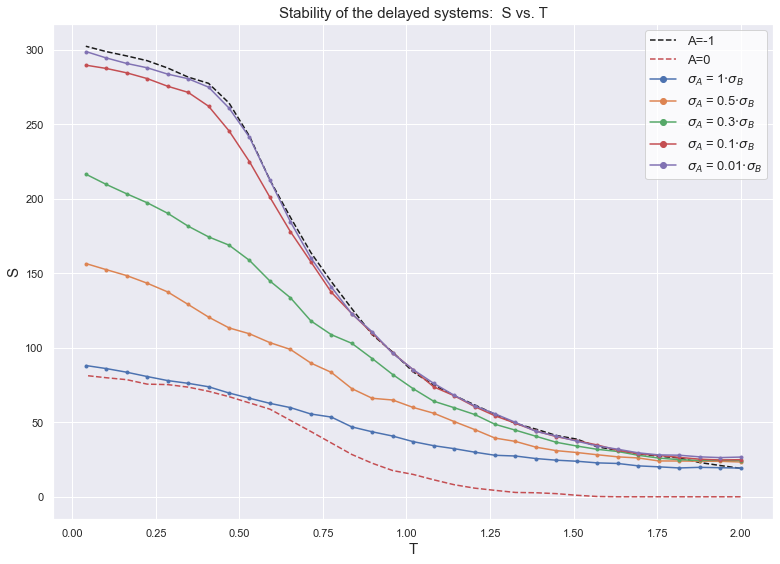

In [28]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(11,8)

plt.plot(Tvec,S_val_1,'k--',label='A=-1')
plt.plot(Tvec,S_val_0,'r--',label='A=0')
for k,multiplier in enumerate(multi):
    plt.plot(Tvec,S_val1[:,k],'.-',label=f'$\sigma_A$ = {multiplier}$\cdot\sigma_B$')

#plt.plot(Tvec,S_val_0,'.-')
#plt.plot(Tvec,S_val_11,'.-')

plt.xlabel('T',fontsize=15)
plt.ylabel('S',fontsize=15)
#plt.yscale('log')
plt.title("Stability of the delayed systems:  S vs. T",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper right',facecolor='w')

fig.tight_layout()
plt.show(fig)
#fig.savefig('Stability_perturbation_ran_C0.6_s0.15.png',format='png')